# NLP Deep Dive: RNNs

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
%cd '/gdrive/My Drive/Colab Notebooks'

/gdrive/My Drive/Colab Notebooks


In [3]:
!pip install fastai2 -q

     |████████████████████████████████| 194kB 9.4MB/s 


In [4]:
from fastai2.text.all import *
path = untar_data(URLs.IMDB_SAMPLE) # we use only a sample of the whole dataset!

In [0]:
path.ls()

(#1) [Path('/root/.fastai/data/imdb_sample/texts.csv')]

In [0]:
df = pd.read_csv(f'{path}/texts.csv')
df.head(3)

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False


### Language Model

In [0]:
imdb_lm = DataBlock(blocks=TextBlock.from_df('text', is_lm=True),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter(0.1))

In [0]:
dls = imdb_lm.dataloaders(df, bs=64, seq_len=72)

In [0]:
dls.vocab[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the']

In [0]:
dls.show_batch(max_n=3)

,text,text_
0,"xxbos xxmaj this movie was the most horrible movie watching experience i have ever had to endure , and what is worse is the fact that i had to watch it , and did n't have the opportunity to stop it because it was for school ! xxmaj admittedly , the storyline was decent … but i found the acting terrible ! xxmaj the exception was xxmaj xxunk jean - xxunk ,","xxmaj this movie was the most horrible movie watching experience i have ever had to endure , and what is worse is the fact that i had to watch it , and did n't have the opportunity to stop it because it was for school ! xxmaj admittedly , the storyline was decent … but i found the acting terrible ! xxmaj the exception was xxmaj xxunk jean - xxunk , i"
1,thing was so surprisingly stunning and it really was a mystery not because it has so many secrets but because there was nothing like it before everything was so great . i literally became xxunk to it . xxup lost is a classic work of art . xxmaj it gives you something to look forward to every week . xxmaj it is genius . xxmaj the surrounding is brilliant it is calm,was so surprisingly stunning and it really was a mystery not because it has so many secrets but because there was nothing like it before everything was so great . i literally became xxunk to it . xxup lost is a classic work of art . xxmaj it gives you something to look forward to every week . xxmaj it is genius . xxmaj the surrounding is brilliant it is calm and
2,"'s xxunk style worked exceptionally well on xxmaj united xxunk which was a sentiment xxunk desperate to happen , but on xxmaj bourne and his xxunk xxunk it just has the effect of xxunk the audience from involvement with the character . xxmaj he runs . xxmaj he jumps . xxmaj he punches . xxmaj he gets blown up . xxmaj he xxunk tall buildings . xxmaj yada yada yada . xxmaj","xxunk style worked exceptionally well on xxmaj united xxunk which was a sentiment xxunk desperate to happen , but on xxmaj bourne and his xxunk xxunk it just has the effect of xxunk the audience from involvement with the character . xxmaj he runs . xxmaj he jumps . xxmaj he punches . xxmaj he gets blown up . xxmaj he xxunk tall buildings . xxmaj yada yada yada . xxmaj above"


In [0]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.3).to_fp16()

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=9.12010818865383e-07)

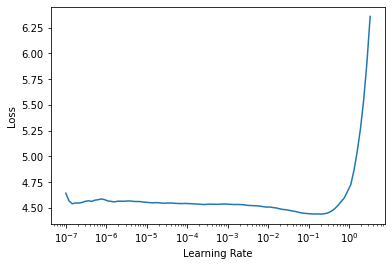

In [0]:
learn.lr_find()

In [0]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,time
0,4.277908,3.981493,00:39
1,3.990768,3.941666,00:39


In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,time
0,3.773966,3.881823,00:47
1,3.669880,3.869076,00:47


In [0]:
learn.save_encoder('encoder')

In [0]:
text = 'I think this movie'
n_words = 20
n_sentences=3

In [0]:
print('\n'.join(learn.predict(text, n_words) for _ in range(n_sentences)))

i think this movie is just supposed to be funny , psychological unfortunately . The Hitler Family , which has held
i think this movie has a good kind of feel to it as well . This movie drags a little bit into after
i think this movie does n't get back up costs , and so they get a black figure dead and their country , fitting


### Classifier

In [0]:
blocks = (TextBlock.from_df('text', seq_len=dls.seq_len, vocab=dls.vocab, is_lm=False), CategoryBlock())

In [0]:
imdb_clas = DataBlock(blocks=blocks,
                      get_x=ColReader('text'),
                      get_y=ColReader('label'),
                      splitter=ColSplitter(col='is_valid'))

In [0]:
dls_clas = imdb_clas.dataloaders(df, bs=64)

In [0]:
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and gooey , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and gooey xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive


In [0]:
learn_clas = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy).to_fp16()
learn_clas.load_encoder('encoder')

In [0]:
learn_clas.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.806539,0.631196,0.640000,00:12


epoch,train_loss,valid_loss,accuracy,time
0,0.575967,0.592163,0.700000,00:35
1,0.574282,0.506847,0.790000,00:34
2,0.510945,0.468568,0.805000,00:34
3,0.480786,0.458085,0.830000,00:33
4,0.455951,0.452206,0.810000,00:35


In [0]:
learn_clas.predict("I really loved that movie, it was awesome!")

('positive', tensor(1), tensor([5.4334e-05, 9.9995e-01]))

In [0]:
learn_clas.export(fname='imdb-sample.pkl')

In [0]:
import pathlib
pathlib.Path.cwd().ls(file_exts='.pkl') # just to make sure the model has been saved

(#1) [Path('/gdrive/My Drive/Colab Notebooks/imdb-sample.pkl')]

### returning to work to make predictions

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
%cd '/gdrive/My Drive/Colab Notebooks'

/gdrive/My Drive/Colab Notebooks


In [0]:
!pip install fastai2 -q
from fastai2.text.all import *

In [0]:
learn_inf = load_learner('imdb-sample.pkl')

In [5]:
learn_inf.predict('I really loved that movie, it was awesome!')

('positive', tensor(1), tensor([5.4380e-05, 9.9995e-01]))

In [6]:
learn_inf.predict('Great cast but the movie sucks.')

('positive', tensor(1), tensor([0.2116, 0.7884]))

In [21]:
# let's make sure our classifier is truly sure about the review class

def predict(review):
    result = learn_inf.predict(review)
    if result[2][result[1].numpy()].numpy() >= 0.95:
      return result[0]
    else:
      return 'inconclusive'

review = 'Great cast but the movie sucks.'
print(f'{review} -> {predict(review)}')

review = 'This movie was simply perfect'
print(f'{review} -> {predict(review)}')

review = 'I loved this movie, great acting!'
print(f'{review} -> {predict(review)}')

Great cast but the movie sucks. -> inconclusive


This movie was simply perfect -> positive


I loved this movie, great acting! -> positive
